# Imports

In [12]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

# Pure python function

In [34]:
def solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy):
    row, col = u.shape
    # setting the initial condition
    u[int(.5/dy):int(1/dy + 1), int(.5/dx):int(1/dx + 1)] = 2
    v[int(.5/dy):int(1/dy + 1), int(.5/dx):int(1/dx + 1)] = 2
    for n in range(nt):
        for j in range(col):
            for k in range(col):
                un[j, k] = u[j, k]
                vn[j, k] = v[j, k]
        for i in range(1, row-1):
            for j in range(1, col-1):
                u[i,j] = un[i,j] - (dt/dx)*un[i,j]*(un[i,j] - un[i-1,j])
                u[i,j] = u[i,j] - (dt/dy)*vn[i,j]*(un[i,j] - un[i,j-1])
                v[i,j] = vn[i,j] - (dt/dx)*un[i,j]*(vn[i,j] - vn[i-1,j])
                v[i,j] = v[i,j] - (dt/dy)*vn[i,j]*(vn[i,j] - vn[i,j-1])
    return 0

# Numba accelerator

In [35]:
@njit(fastmath=True)
def solve_2d_nonlinearconv_numba(u, un, v, vn, nt, dt, dx, dy):
    row, col = u.shape
    # setting the initial condition
    u[int(.5/dy):int(1/dy + 1), int(.5/dx):int(1/dx + 1)] = 2
    v[int(.5/dy):int(1/dy + 1), int(.5/dx):int(1/dx + 1)] = 2
    for n in range(nt):
        for j in range(col):
            for k in range(col):
                un[j, k] = u[j, k]
                vn[j, k] = v[j, k]
        for i in range(1, row-1):
            for j in range(1, col-1):
                u[i,j] = un[i,j] - (dt/dx)*un[i,j]*(un[i,j] - un[i-1,j])
                u[i,j] = u[i,j] - (dt/dy)*vn[i,j]*(un[i,j] - un[i,j-1])
                v[i,j] = vn[i,j] - (dt/dx)*un[i,j]*(vn[i,j] - vn[i-1,j])
                v[i,j] = v[i,j] - (dt/dy)*vn[i,j]*(vn[i,j] - vn[i,j-1])
    return 0

# Pyccel accelerator

In [36]:
@types('float[:,:]', 'float[:,:]', 'float[:,:]', 'float[:,:]', 'int', 'float', 'float','float')
def solve_2d_nonlinearconv_pyccel(u, un, v, vn, nt, dt, dx, dy):
    row, col = u.shape
    # setting the initial condition
    u[int(.5/dy):int(1/dy + 1), int(.5/dx):int(1/dx + 1)] = 2
    v[int(.5/dy):int(1/dy + 1), int(.5/dx):int(1/dx + 1)] = 2
    for n in range(nt):
        for j in range(col):
            for k in range(col):
                un[j, k] = u[j, k]
                vn[j, k] = v[j, k]
        for i in range(1, row-1):
            for j in range(1, col-1):
                u[i,j] = un[i,j] - (dt/dx)*un[i,j]*(un[i,j] - un[i-1,j])
                u[i,j] = u[i,j] - (dt/dy)*vn[i,j]*(un[i,j] - un[i,j-1])
                v[i,j] = vn[i,j] - (dt/dx)*un[i,j]*(vn[i,j] - vn[i-1,j])
                v[i,j] = v[i,j] - (dt/dy)*vn[i,j]*(vn[i,j] - vn[i,j-1])
    return 0    

# Inputs

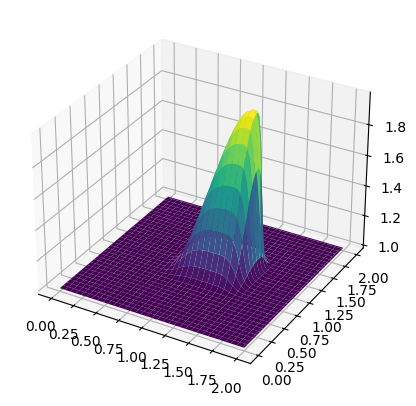

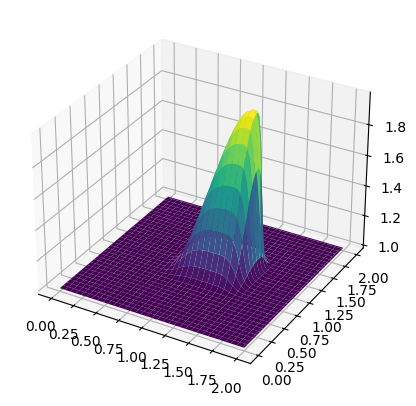

In [37]:
###variable declarations
nx = 101
ny = 101
nt = 80
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))     

solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

# Call Functions

# Pure function

In [38]:
%timeit solve_2d_nonlinearconv_pure(u, un, v, vn, nt, dt, dx, dy)

1 loop, best of 3: 3.77 s per loop


# Function with numba accelerator

In [39]:
%timeit solve_2d_nonlinearconv_numba(u, un, v, vn, nt, dt, dx, dy)

The slowest run took 108.11 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 4.56 ms per loop


# Function with pyccel accelerator

In [40]:
solve_2d_nonlinearconv_f90 = epyccel(solve_2d_nonlinearconv_pyccel)

In [41]:
%timeit solve_2d_nonlinearconv_f90(u, un, v, vn, nt, dt, dx, dy)

100 loops, best of 3: 2.54 ms per loop
